In [1]:
from tardis.io.atom_data import AtomData
from tardis.plasma.detailed_balance.rates import (
    RadiativeRatesSolver,
    ThermalCollisionalRateSolver,
    UpsilonRegemorterSolver,
)
from tardis.plasma.radiation_field import (
    PlanckianRadiationField,
)

from astropy import units as u

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
from tardis.model.base import SimulationState
from tardis.io.configuration.config_reader import Configuration

config = Configuration.from_yaml("test_continuum_template_wkerzen_rate_coeffs.yml")

In [3]:
def get_radiative_rates(rad_field, radiative_transitions):
    rad_rate_solver = RadiativeRatesSolver(radiative_transitions)
    return rad_rate_solver.solve(rad_field)

In [4]:
def get_estimated_upsilon_rates(temperature, radiative_transitions):
    col_strength_solver = UpsilonRegemorterSolver(radiative_transitions)
    return col_strength_solver.solve(temperature)

In [5]:
def get_cmfgen_collisional_rates(atom_data, temperature, radiative_transitions,):
    col_strength_temperatures = atom_data.collision_data_temperatures
    col_strengths = atom_data.yg_data.loc[(1,0, slice(None), slice(None)), :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'cmfgen')
    return collisional_rate_solver.solve(temperature)

In [6]:
def get_chianti_collisional_rates(atom_data, temperature, radiative_transitions,):
    col_strength_temperatures = atom_data.collision_data_temperatures
    col_strengths = atom_data.collision_data.loc[(1,0, slice(None), slice(None)), :]
    collisional_rate_solver = ThermalCollisionalRateSolver(atom_data.levels, radiative_transitions, col_strength_temperatures, col_strengths, 'chianti')
    return collisional_rate_solver.solve(temperature)

## Chianti rates

In [7]:
chianti_atom_data = AtomData.from_hdf('/home/afullard/carsus/docs/kurucz_cd23_chianti_H_He.h5')
chianti_radiative_transitions = chianti_atom_data.lines.loc[(1,0, slice(None), slice(None)), :]

In [8]:
import pandas as pd

chianti_sim_state = SimulationState.from_config(config, atom_data=chianti_atom_data)

reference_coeff = pd.HDFStore("collisional_rate_coefficients.hdf")
reference_rate_coeff_df = pd.concat([reference_coeff["coll_exc_coeff"], reference_coeff["coll_deexc_coeff"].reorder_levels([0,1,3,2])])

temperature = reference_coeff["t_electrons"].values * u.K
rad_field = PlanckianRadiationField(temperature=temperature)

Number of density points larger than number of shells. Assuming inner point irrelevant


Chianti data comes from Carsus as `g_ratio = g_lower / g_upper`, `delta_E = energy_upper - energy_lower`, and a table of `beta_coll * upsilon / (g_upper * sqrt(T))`. See eq 9.57 Hubeny and Mihelas. Multiply by the boltzmann factor `exp(-delta_E / k * T)` to get the excitation rate. De-excitation rate should be `Excitation rate * (g_upper / g_lower) / boltzmann_factor` which for the Chianti data is `Excitation rate * (1 / g_ratio) / boltzmann_factor`

In [9]:
chianti_radiative_rates = get_radiative_rates(rad_field, chianti_radiative_transitions)

In [10]:
chianti_upsilon_rates = get_estimated_upsilon_rates(temperature, chianti_radiative_transitions)

In [11]:
chianti_collisional_rates = get_chianti_collisional_rates(chianti_atom_data, temperature, chianti_radiative_transitions)

Raw Chianti upsilon/g values currently differ from CMFGEN by factor of ~10^-7. Delta energies are the same (within data error). Chianti level data is very different. `g` values are basically the same ballpark though. Conversion of Chianti rate data into upsilon/g seems correct, but there may be an extra Boltzmann factor in the Chianti data. Changed to divide by lower level `g` to match CMFGEN.

<Axes: xlabel='Shell', ylabel='Coeff'>

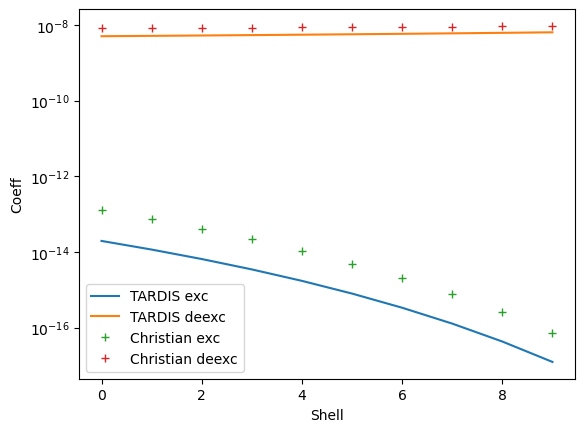

In [13]:
chianti_collisional_rates.loc[1,0,0,1].plot(logy=True,label="TARDIS exc",legend=True)
chianti_collisional_rates.loc[1,0,1,0].plot(logy=True,label="TARDIS deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,0,1].plot(logy=True,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,0,1].plot(logy=True,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

<Axes: xlabel='Shell', ylabel='Coeff'>

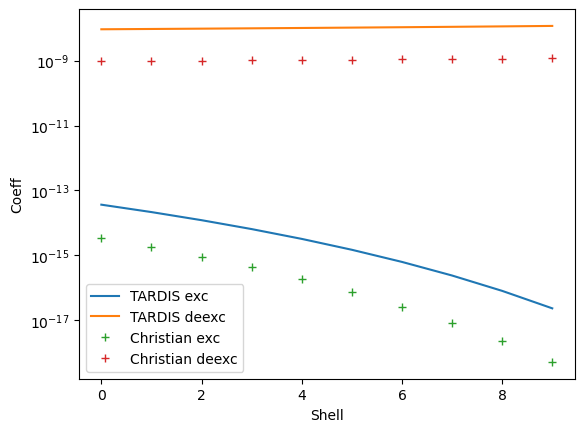

In [14]:
chianti_collisional_rates.loc[1,0,0,2].plot(logy=True,label="TARDIS exc",legend=True)
chianti_collisional_rates.loc[1,0,2,0].plot(logy=True,label="TARDIS deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,0,2].plot(logy=True,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,0,2].plot(logy=True,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

<Axes: xlabel='Shell', ylabel='Coeff'>

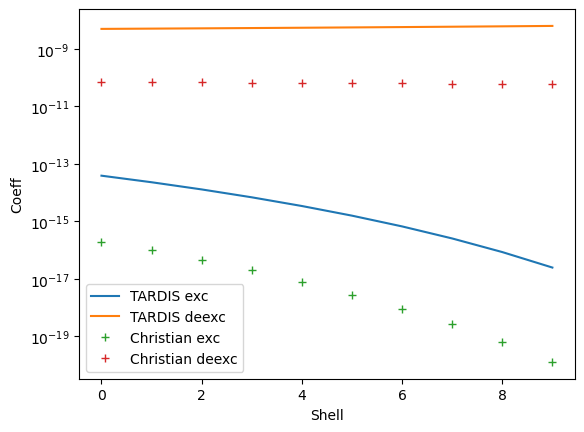

In [15]:
chianti_collisional_rates.loc[1,0,0,3].plot(logy=True,label="TARDIS exc",legend=True)
chianti_collisional_rates.loc[1,0,3,0].plot(logy=True,label="TARDIS deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,0,3].plot(logy=True,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,0,3].plot(logy=True,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

## CMFGEN collisional rates

In [17]:
cmfgen_atom_data = AtomData.from_hdf('/home/afullard/tardis-refdata/nlte_atom_data/TestNLTE_He_Ti.h5')
cmfgen_radiative_transitions = cmfgen_atom_data.lines.loc[(1,0, slice(None), slice(None)), :]

In [18]:
cmfgen_sim_state = SimulationState.from_config(config, atom_data=cmfgen_atom_data)

temperature = reference_coeff["t_electrons"].values * u.K
rad_field = PlanckianRadiationField(temperature=temperature)

Number of density points larger than number of shells. Assuming inner point irrelevant


In [19]:
cmfgen_radiative_rates = get_radiative_rates(rad_field, cmfgen_radiative_transitions)

In [20]:
cmfgen_upsilon_rates = get_estimated_upsilon_rates(temperature, cmfgen_radiative_transitions)

In [21]:
cmfgen_collisional_rates = get_cmfgen_collisional_rates(cmfgen_atom_data, temperature, cmfgen_radiative_transitions)

In [22]:
cmfgen_collisional_rates

0  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         1.267799e-13   
                                             2                         3.356946e-15   
                                             3                         1.989207e-16   
                                             4                         1.370295e-16   
                                             5                         6.270420e-17   
...                                                                             ...   
                         28                  26                        7.195997e-03   
                         29                  26                        1.417282e-03   
                         28                  27                        1.326055e-01   
                         29                  27                        8.433900e-03   
                                             28                        1.551432e-01   

                                                                                  1  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         7.409859e-14   
                                             2                         1.788862e-15   
                                             3                         9.873436e-17   
                                             4                         6.868098e-17   
                                             5                         3.114708e-17   
...                                                                             ...   
                         28                  26                        7.293750e-03   
                         29                  26                        1.436124e-03   
                         28                  27                        1.345468e-01   
                         29                  27                        8.553185e-03   
                                             28                        1.574200e-01   

                                                                                  2  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         4.118523e-14   
                                             2                         8.989059e-16   
                                             3                         4.586649e-17   
                                             4                         3.227971e-17   
                                             5                         1.449558e-17   
...                                                                             ...   
                         28                  26                        7.396148e-03   
                         29                  26                        1.455952e-03   
                         28                  27                        1.365893e-01   
                         29                  27                        8.679063e-03   
                                             28                        1.598144e-01   

                                                                                  3  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         2.162077e-14   
                                             2                         4.223418e-16   
                                             3                         1.978074e-17   
                                             4                         1.410044e-17   
                                             5                         6.263862e-18   
...                                                                          

In [23]:
chianti_collisional_rates

0  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         1.947332e-14   
                                             2                         3.641834e-14   
                                             3                         3.896169e-14   
                                             4                         5.387536e-16   
                                             5                         1.026299e-15   
...                                                                             ...   
                         20                  14                        1.012879e-08   
                         23                  14                        1.613469e-05   
                         20                  15                        2.025768e-07   
                         23                  15                        1.153401e-06   
                         24                  15                        1.848863e-05   

                                                                                  1  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         1.150685e-14   
                                             2                         2.151969e-14   
                                             3                         2.302253e-14   
                                             4                         2.876504e-16   
                                             5                         5.479599e-16   
...                                                                             ...   
                         20                  14                        1.010773e-08   
                         23                  14                        1.610114e-05   
                         20                  15                        2.021555e-07   
                         23                  15                        1.151002e-06   
                         24                  15                        1.845018e-05   

                                                                                  2  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         6.471781e-15   
                                             2                         1.210328e-14   
                                             3                         1.294850e-14   
                                             4                         1.448241e-16   
                                             5                         2.758829e-16   
...                                                                             ...   
                         20                  14                        1.008320e-08   
                         23                  14                        1.606207e-05   
                         20                  15                        2.016650e-07   
                         23                  15                        1.148210e-06   
                         24                  15                        1.840541e-05   

                                                                                  3  \
atomic_number ion_number level_number_source level_number_destination                 
1             0          0                   1                         3.439696e-15   
                                             2                         6.432783e-15   
                                             3                         6.881995e-15   
                                             4                         6.817268e-17   
                                             5                         1.298656e-16   
...                                                                          

In [24]:
assert cmfgen_collisional_rates.shape == reference_rate_coeff_df.shape

In [25]:
pd.testing.assert_frame_equal(cmfgen_collisional_rates.sort_index() * (1-0.000015),reference_rate_coeff_df.sort_index(),check_names=False)

In [26]:
reference_rate_coeff_df = reference_rate_coeff_df.sort_index()

In [27]:
reference_rate_coeff_df.index.names=cmfgen_collisional_rates.sort_index().index.names

In [28]:
(cmfgen_collisional_rates - reference_rate_coeff_df) / reference_rate_coeff_df

0  \
atomic_number ion_number level_number_source level_number_destination             
1             0          0                   1                         0.000015   
                                             2                         0.000015   
                                             3                         0.000015   
                                             4                         0.000015   
                                             5                         0.000015   
...                                                                         ...   
                         29                  24                        0.000015   
                                             25                        0.000015   
                                             26                        0.000015   
                                             27                        0.000015   
                                             28                        0.000015   

                                                                              1  \
atomic_number ion_number level_number_source level_number_destination             
1             0          0                   1                         0.000015   
                                             2                         0.000015   
                                             3                         0.000015   
                                             4                         0.000015   
                                             5                         0.000015   
...                                                                         ...   
                         29                  24                        0.000015   
                                             25                        0.000015   
                                             26                        0.000015   
                                             27                        0.000015   
                                             28                        0.000015   

                                                                              2  \
atomic_number ion_number level_number_source level_number_destination             
1             0          0                   1                         0.000015   
                                             2                         0.000015   
                                             3                         0.000015   
                                             4                         0.000015   
                                             5                         0.000015   
...                                                                         ...   
                         29                  24                        0.000015   
                                             25                        0.000015   
                                             26                        0.000015   
                                             27                        0.000015   
                                             28                        0.000015   

                                                                              3  \
atomic_number ion_number level_number_source level_number_destination             
1             0          0                   1                         0.000015   
                                             2                         0.000015   
                                             3                         0.000015   
                                             4                         0.000015   
                                             5                         0.000015   
...                                                                         ...   
                         29                  24                        0.000015   
                                             25                        0.000015   
        

In [29]:
from tardis import constants as const
import numpy as np
beta_coll = (
    (const.h**4 / (8 * const.k_B * const.m_e**3 * np.pi**3)) ** 0.5
).cgs

In [30]:
abs(8.63e-6 - beta_coll.value) / min(8.63e-6, beta_coll.value)

0.00010054083203834371

<Axes: xlabel='Shell', ylabel='Coeff'>

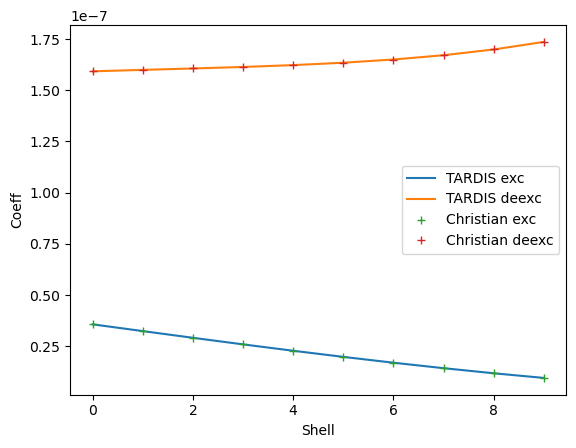

In [31]:
cmfgen_collisional_rates.loc[1,0,1,2].plot(logy=False,label="TARDIS exc",legend=True)
cmfgen_collisional_rates.loc[1,0,2,1].plot(logy=False,label="TARDIS deexc",legend=True)
#plasma.coll_exc_coeff.loc[1,0,1,2].plot(logy=True,label="TARDIS old exc",legend=True)
#plasma.coll_deexc_coeff.loc[1,0,1,2].plot(logy=True,label="TARDIS old deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,1,2].plot(logy=False,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,1,2].plot(logy=False,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

<Axes: xlabel='Shell', ylabel='Coeff'>

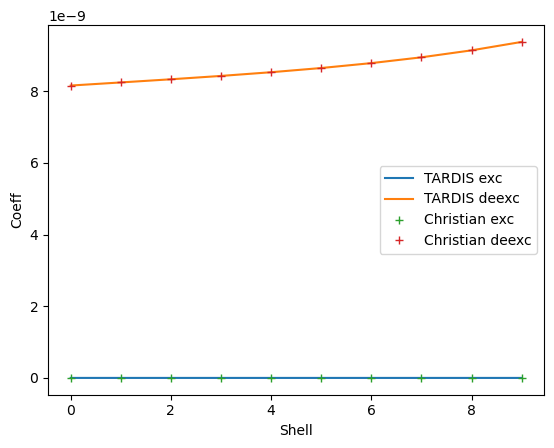

In [32]:
cmfgen_collisional_rates.loc[1,0,0,1].plot(logy=False,label="TARDIS exc",legend=True)
cmfgen_collisional_rates.loc[1,0,1,0].plot(logy=False,label="TARDIS deexc",legend=True)
#plasma.coll_exc_coeff.loc[1,0,1,2].plot(logy=True,label="TARDIS old exc",legend=True)
#plasma.coll_deexc_coeff.loc[1,0,1,2].plot(logy=True,label="TARDIS old deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,0,1].plot(logy=False,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,0,1].plot(logy=False,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

<Axes: xlabel='Shell', ylabel='Coeff'>

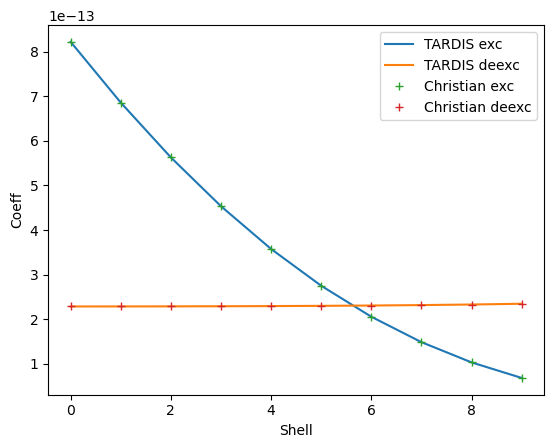

In [33]:
cmfgen_collisional_rates.loc[1,0,1,29].plot(logy=False,label="TARDIS exc",legend=True)
cmfgen_collisional_rates.loc[1,0,29,1].plot(logy=False,label="TARDIS deexc",legend=True)
reference_coeff["coll_exc_coeff"].loc[1,0,1,29].plot(logy=False,label="reference exc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')
reference_coeff["coll_deexc_coeff"].loc[1,0,1,29].plot(logy=False,label="reference deexc",legend=True,ylabel="Coeff",xlabel="Shell",ls="", marker = '+')

<Axes: xlabel='Shell', ylabel='Coeff'>

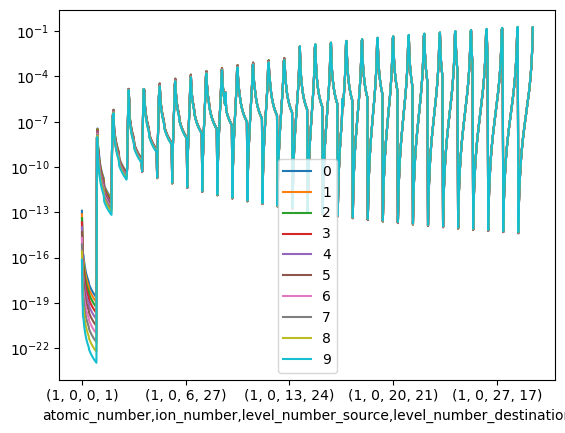

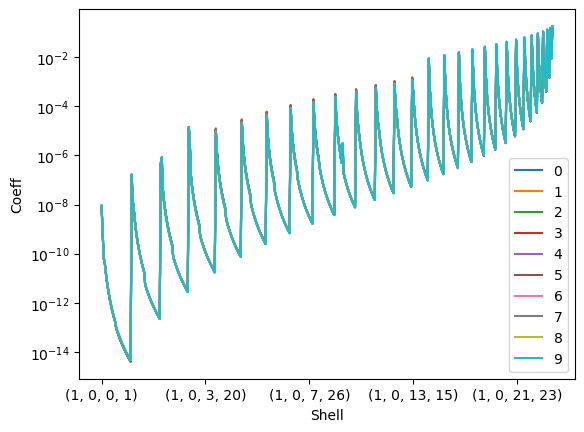

In [34]:
cmfgen_collisional_rates.sort_index().plot(logy=True,label="TARDIS",legend=True)
reference_coeff["coll_deexc_coeff"].sort_index().plot(logy=True,label="reference",legend=True,ylabel="Coeff",xlabel="Shell")

<Axes: xlabel='atomic_number,ion_number,level_number_source,level_number_destination'>

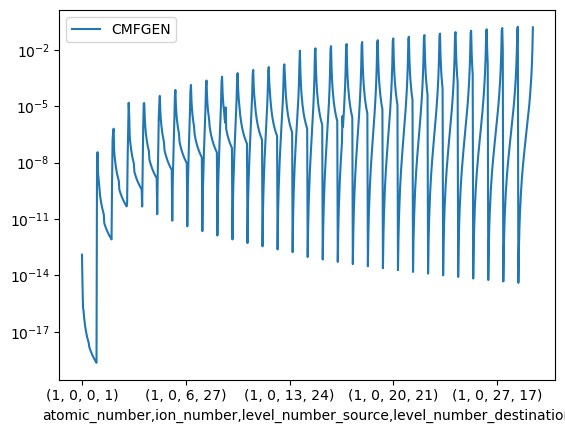

In [35]:
cmfgen_collisional_rates[0].sort_index().plot(logy=True,label="CMFGEN",legend=True)

<Axes: xlabel='atomic_number,ion_number,level_number_source,level_number_destination', ylabel='Coeff'>

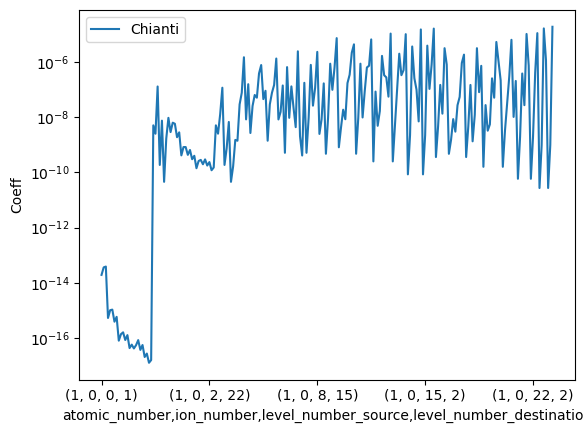

In [36]:
chianti_collisional_rates[0].sort_index().plot(logy=True,label="Chianti",legend=True, ylabel="Coeff")

In [37]:
chianti_collisional_rates_full = chianti_collisional_rates.reindex(cmfgen_collisional_rates.index)

<Axes: xlabel='atomic_number,ion_number,level_number_source,level_number_destination', ylabel='Coeff'>

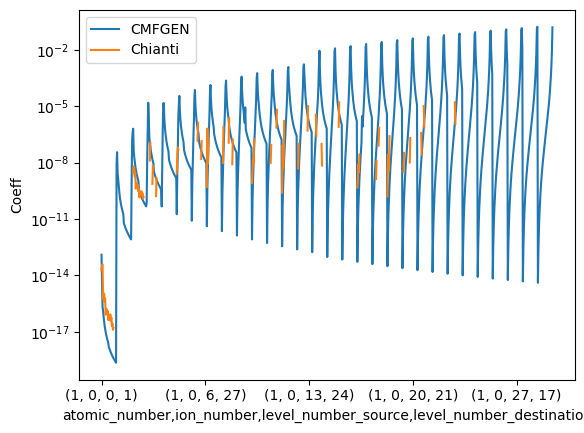

In [38]:
cmfgen_collisional_rates[0].sort_index().plot(logy=True,label="CMFGEN",legend=True)
chianti_collisional_rates_full[0].sort_index().plot(logy=True,label="Chianti",legend=True, ylabel="Coeff")

In [39]:
chianti_atom_data_old = AtomData.from_hdf('/home/afullard/tardis-refdata/atom_data/kurucz_atom_chianti_many.h5')
chianti_atom_data_old.prepare_atom_data([1],'macroatom',[(1, 0)],[])
coll_matrix = chianti_atom_data_old.nlte_data.get_collision_matrix((1,0), temperature.value)

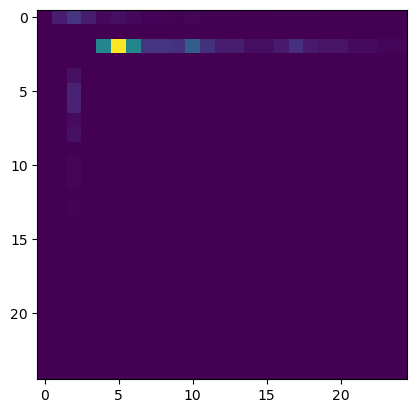

In [40]:
import matplotlib.pyplot as plt

plt.imshow(coll_matrix[:,:,0])

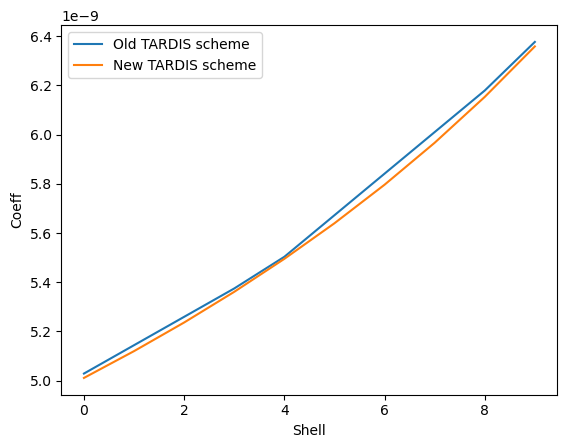

In [41]:
plt.plot(coll_matrix[0,1,:],label="Old TARDIS scheme")
plt.plot(chianti_collisional_rates.loc[1,0,1,0],label="New TARDIS scheme")
plt.xlabel("Shell")
plt.ylabel("Coeff")
plt.legend()

In [42]:
(coll_matrix[0,1,:] - chianti_collisional_rates.loc[1,0,1,0]) / chianti_collisional_rates.loc[1,0,1,0]

0    0.003541
1    0.004709
2    0.004400
3    0.002548
4    0.001518
5    0.005794
6    0.007756
7    0.007275
8    0.004203
9    0.002876
Name: (1, 0, 1, 0), dtype: float64

In [43]:
coll_matrix[1,0,:] / chianti_collisional_rates.loc[1,0,0,1]

0    1.003542
1    1.004710
2    1.004401
3    1.002549
4    1.001519
5    1.005795
6    1.007757
7    1.007276
8    1.004205
9    1.002877
Name: (1, 0, 0, 1), dtype: float64

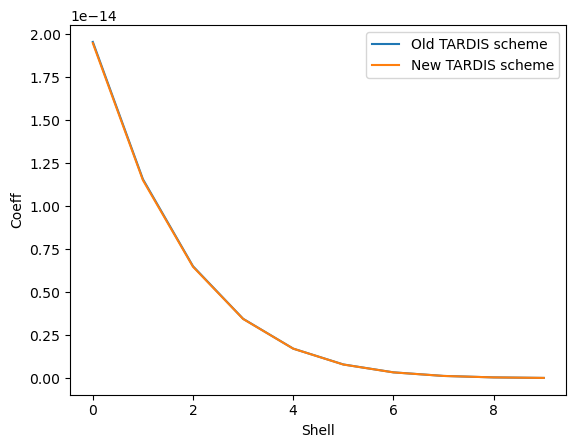

In [44]:
plt.plot(coll_matrix[1,0,:],label="Old TARDIS scheme")
plt.plot(chianti_collisional_rates.loc[1,0,0,1],label="New TARDIS scheme")
plt.xlabel("Shell")
plt.ylabel("Coeff")
plt.legend()